## Use the active subspace method on a reduced order cardiovascular model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
## Active subspace methods

import numpy as np
from scipy.linalg import svd
from scipy.stats import qmc

In [75]:


def ActiveSubspace_SVD_Algorithm(f, UB, LB, M, Ny, CS_flag, param_ids, param_base):
    """
    Implements active subspace methods using Singular Value Decomposition (SVD).

    Parameters:
        f : function
            Quantity of interest function.
        UB : numpy array
            Upper bounds for parameters.
        LB : numpy array
            Lower bounds for parameters.
        M : int
            Number of samples.
        Ny : int
            Output dimensions.
        CS_flag : int
            0 for finite differences, 1 for complex step method.
        param_ids : list
            Indices of active parameters.
        param_base : numpy array
            Base parameter values.
        parallel_flag : int
            0 for sequential execution, 1 for parallel execution.

    Returns:
        G_f : numpy array
            Scaled gradient matrix.
        Lambda : numpy array
            Singular values of G_f.
        W : numpy array
            Rotation matrix.
        act_scores : numpy array
            Activity scores indicating parameter sensitivity.
    """

    ids_fix = list(range(len(UB)))
    for idx in param_ids:
        ids_fix.remove(idx)

    num_param = len(param_ids)
    UB = UB[param_ids]
    LB = LB[param_ids]

    # Latin hypercube sampling
    lhs = qmc.LatinHypercube(num_param).random(M)
    X = LB + (UB - LB) * lhs

    h = 1e-6
    par_LHS = np.zeros((len(param_ids) + len(ids_fix), M))
    for i in range(M):
        par_LHS[ids_fix,i] =  param_base[ids_fix]
        par_LHS[param_ids, i] = X[i,:]

    G_f = np.zeros((num_param, M))

    # Compute gradients
    I_h = np.eye(len(param_ids) + len(ids_fix)) * h
    n_par = np.size(param_ids)
    if CS_flag == 0:  # Forward finite difference method
        for i in range(M):
            grad_f = np.zeros((num_param, Ny))
            # print(par_LHS[:, i] + I_h[1, :])
            fbase = f(par_LHS[:,i])
            for j in range(n_par):
                # Centered difference
                # par_plus = par_LHS[:, i] + I_h[param_ids[j], :]
                # par_minus = par_LHS[:, i] - I_h[param_ids[j], :]
                # fstepP = f(par_plus)
                # fstepM = f(par_minus)
                # grad_f[j, :] = 0.5 * (fstepP - fstepM) / h
                # Forward difference
                par_plus = par_LHS[:, i] + I_h[param_ids[j], :]
                fstepP = f(par_plus)
                grad_f[j, :] = (fstepP - fbase) / h
                # print(param_ids[j],grad_f[j, :], par_plus)
            if int(i / M * 100) % 10 == 0:
                print(f"{int(i / M * 100)} percent complete.")

            G_f[:, i] = grad_f.ravel()
    else:  # Complex step method
        I_h = np.eye(len(param_ids) + len(ids_fix)) * h * 1j
        for i in range(M):
            grad_f = np.zeros((num_param, Ny))
            for j in range(n_par):
                fstepP = f(par_LHS[:, i] + I_h[param_ids[j], :])
                grad_f[j, :] = np.imag(fstepP) / h
                print(np.imag(fstepP) / h)
            if int(i / M * 100) % 10 == 0:
                print(f"{int(i / M * 100)} percent complete.")
            G_f[:, i] = grad_f.ravel()

    G_f /= np.sqrt(M)

    # Singular value decomposition
    W, Lambda, _ = svd(G_f, full_matrices=False)
    act_scores = np.sum((Lambda ** 2) * (W.T ** 2), axis=1)

    return G_f, Lambda, W, act_scores


In [76]:
# SIR model function
def SIR_model(t,y, params):
    # Unpack parameters
    N = 1000
    gamma, k, r, mu = params
    # Redefine state variables
    S, I, R = y

    # RHS equations
    dSdt = mu*N - mu*S - gamma*k*I*S
    dIdt = gamma*k*I*S - (r + mu)*I
    dRdt = r*I - mu*R
    return [dSdt, dIdt, dRdt]



In [77]:

# Define parameter names
param_names = ['gamma','k','mu','r']
param = np.array([0.2,0.2,0.2,0.2])
IC = np.array([999,1,0])
# Define time space
tstart = 0
tend = 100
dt = 1e-1
tspace = np.arange(tstart, tend, dt)
param_base = param.copy()

def act_subspace_f(q):
    solver_options = {'rtol': 1e-8, 'atol': 1e-8}
    solution = solve_ivp(lambda t, y: SIR_model(t, y, q), 
                    [tspace[0], tspace[-1]], IC, method='RK45', **solver_options)
    infect = solution.y[1,:]
    return np.max(infect)

# Set up active subspace parameters
param_ids = [0,1,2,3] # Adjusted for zero-based indexing
UB = np.array([1,1,1,1])
LB = np.array([0.1,0.1,0.1,0.1])

M = 100
Ny = 1
CS_flag = 0  # Use complex step; otherwise, centered finite difference
parallel_flag = 0

# Run active subspace algorithm
G_f, Lambda, W, act_scores = ActiveSubspace_SVD_Algorithm(act_subspace_f, UB, LB, M, Ny, CS_flag, param_ids, param_base)


0 percent complete.
10 percent complete.
20 percent complete.
30 percent complete.
40 percent complete.
50 percent complete.
60 percent complete.
70 percent complete.
80 percent complete.
90 percent complete.


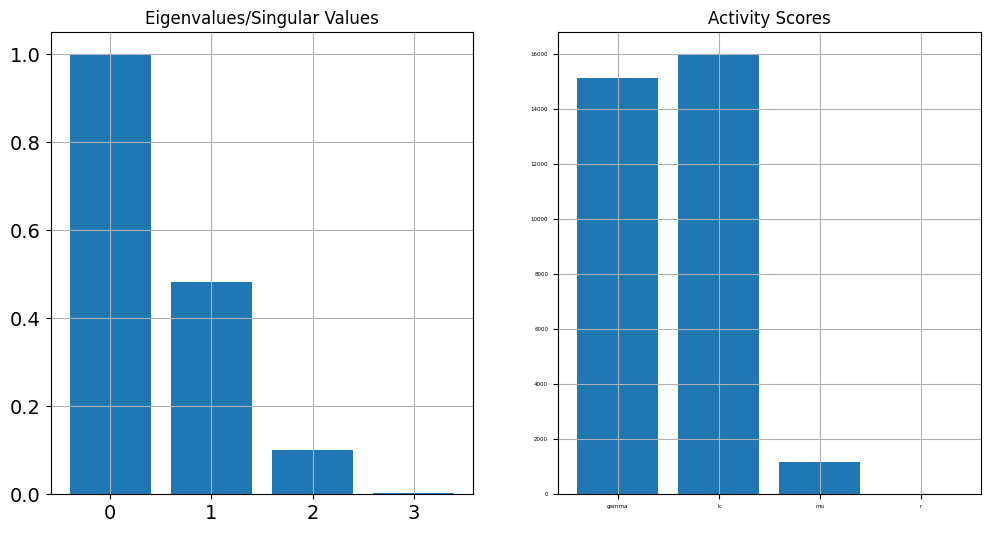

In [78]:
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].bar(range(len(param_ids)), Lambda / np.max(Lambda))
axs[0].set_xticks(range(len(param_ids)))
axs[0].set_title('Eigenvalues/Singular Values')
axs[0].grid(True)
axs[0].tick_params(axis='both', labelsize=14)

axs[1].bar(range(len(param_ids)), act_scores)
axs[1].set_xticks(range(len(param_ids)))
axs[1].set_xticklabels([param_names[i] for i in param_ids])
axs[1].set_title('Activity Scores')
axs[1].grid(True)
axs[1].tick_params(axis='both', labelsize=4)

plt.show()

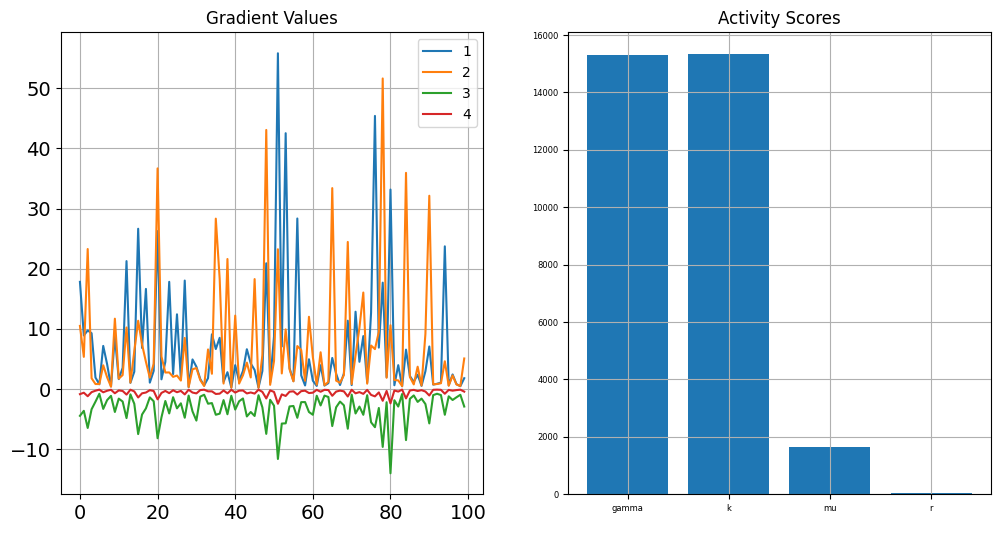

In [79]:
temp = np.sum((Lambda ** 2) * (W ** 2), axis=1)
# Plot results
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(G_f.T)
axs[0].set_title('Gradient Values')
axs[0].grid(True)
axs[0].tick_params(axis='both', labelsize=14)
axs[0].legend(('1','2','3','4','5'))

axs[1].bar(range(len(param_ids)), temp)
axs[1].set_xticks(range(len(param_ids)))
axs[1].set_xticklabels([param_names[i] for i in param_ids])
axs[1].set_title('Activity Scores')
axs[1].grid(True)
axs[1].tick_params(axis='both', labelsize=6)

plt.show()

In [205]:
param

array([5.0e+00, 2.0e+01, 5.0e-03, 1.0e-02, 1.2e+00, 1.1e+00, 1.3e+00,
       3.0e-02, 5.0e+00, 2.5e-01, 5.5e-01, 1.0e+00])